### In this notebook, we're going to have 3 parts: 
1. working on each group seperately (the groups with main themes and the noisy group) - making graphs for them
2. loading all the groups with the main themes and creating CCDF for them
3. loading the recordings of the attacker and attacked in the case where the attacked is active in multiple groups and trying to corelate - to see if we can identify that the attacked is in the group that the attacker is in

In [63]:
work_path = r"C:\Ariel codes\networks\final project\Networks_Final_Project\resources\CLEAN"
name = None

In [64]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [65]:
#time delays between 2 consecutive messages
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = abs(df["Time"].diff().fillna(0)).round(6)

#packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)

In [66]:
def load_csv(number):
    if number == '1':
        name = "whatsappMessagesCSV"
        path = work_path + "/" + name + "Clean.csv"
        print("---------Mixed Group (Mostly Messages)----------")
    elif number == '2':
        name = "whatsappImagesCSV"
        path = work_path + "/" + name + "Clean.csv"
        print("---------Images----------")
    elif number == '3':
        name = "whatsappAudioCSV"
        path = work_path + "/" + name + "Clean.csv"
        print("---------Audio----------")
    elif number == '4':
        name = "whatsappVideosCSV"
        path = work_path + "/" + name + "Clean.csv"
        print("---------Videos----------")
    elif number == '5':
        name = "whatsappFilesCSV"
        path = work_path + "/" + name + "Clean.csv"
        print("---------Files----------")
    elif number == '6':
        name = "WhatsappNoisedGroupCSV"
        path = work_path + "/" + name + "Clean.csv"
        print("---------Group With Noise----------")
    
    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df, name

In [67]:
def plot_activity_trends(df):
    # Plot the message count over time using a line chart
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [68]:
#bar plot of length packetlength changes in time
def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [69]:
#counting the sizes of packets (num of packets in a certain ranges) 
def count_length_ranges(df: pd.DataFrame):
    ranges = {
        "0-50": (0, 50),
        "51-100": (51, 100),
        "100-500": (101, 500),
        "501-1000": (501, 1000),
        "1001-1500": (1001, 1500),
        ">1500": (1501, float("inf"))
    }
    
    range_counts = {range_name: 0 for range_name in ranges}
    
    for range_name, (lower, upper) in ranges.items():
        range_counts[range_name] = ((df["Length"] >= lower) & (df["Length"] <= upper)).sum()
    
    return range_counts

In [70]:
def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(5, 4))
    plt.bar(range_names, counts)
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [71]:
#plot of packet length with the frequency of this packet length
def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

In [72]:
#filtering all packets with length above a certain threshold
def filter_length_above_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] > given]
    return filtered_df

In [73]:
#filtering all packets with length below a certain threshold
def filter_length_below_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] < given]
    return filtered_df

In [74]:
def compute_y_axis_size(df, num_above_threshold=3):
    num_data_points = len(df)
    num_below_threshold = num_data_points - num_above_threshold

    fraction_below_threshold = num_below_threshold / num_data_points
    y_axis_size = df['Length'].quantile(fraction_below_threshold)
    
    return y_axis_size

def colored_bar_plot(df):
    fig, ax = plt.subplots(figsize=(9, 4))

    # Define colors for bars based on the condition
    colors = ['blue' if source != "10.0.2.15" else 'red' for source in df["Source"]]
    
    # Plot bars with the defined colors
    bars = plt.bar(df["Time"], df["Length"], color=colors)
    
    # Create custom bars for the legend
    blue_bar = plt.Rectangle((0,0),1,1,fc="blue", edgecolor='none')
    red_bar = plt.Rectangle((0,0),1,1,fc="red", edgecolor='none')
    
    # Add a legend
    l = plt.legend([blue_bar, red_bar], ['Other IPs', '10.0.0.25'], loc=1, ncol=2, prop={'size':10})
    l.draw_frame(False)
    
    y_axis_size = compute_y_axis_size(df, 3)  # Change the second argument if you want a different number above the threshold
    
    plt.xlim(0, max(df["Time"]) + 50)
    plt.ylim(0, y_axis_size)
    
    plt.yticks(np.arange(0, y_axis_size, 500))
    plt.xticks(np.arange(0, max(df["Time"]) + 50, 50))

    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    

    return y_axis_size, fig


In [75]:
def generate_pdf(df, bins=10):
    """
    Generate the Probability Density Function (PDF) for inter-arrival time.

    Args:
    - df (pd.DataFrame): The dataframe containing Time_delay column.
    - bins (int or sequence): Number of histogram bins or a sequence defining the bin edges.

    Returns:
    - bin_edges (ndarray): The bin edges (length nbins + 1).
    - pdf (ndarray): The values of the PDF.
    """
    
    # Create a histogram of the Time_delay
    counts, bin_edges = np.histogram(df['Time_delay'], bins=bins, density=True)
    
    # Convert counts to probabilities
    pdf = counts / sum(counts)
    
    return bin_edges, pdf

def exponential_dist(x, lambd, scale_factor):
    return scale_factor * lambd * np.exp(-lambd * x)

def plot_pdf_with_fitted_exponential(df, bin_edges, pdf):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotting the outline of the histogram using ax.step
    ax.step(bin_edges[:-1], pdf, where='post', color='blue', lw=2, label='PDF')
    
    # Estimate lambda (rate parameter) from the data
    lambd = 1. / np.mean(df['Time_delay'])
    
    # Compute the bin width from the first two bin edges
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Adjust the scale_factor with respect to bin_width
    scale_factor = max(pdf) / (lambd * np.exp(-lambd * bin_edges[np.argmax(pdf)]))
    
    # Create x values for the fitted exponential curve
    x = np.linspace(0, max(bin_edges), 500)
    
    # Calculate exponential distribution values using the estimated lambda
    y = exponential_dist(x, lambd, scale_factor)
    
    ax.plot(x, y, color='red', lw=2, label='Fitted Exponential Distribution')
    
    ax.set_xlabel('Inter-Arrival Time')
    ax.set_ylabel('Density')
    ax.set_title('PDF of Inter-Arrival Time and Fitted Exponential Distribution')
    ax.legend()
    ax.grid(True)
    plt.show()
    return fig

In [76]:
def plot_time_delay_distribution(df):
    plt.figure(figsize=(10, 6))
    
    plt.hist(df['Time_delay'], bins=50, color='blue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Time Delay')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time Delay')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

In [77]:
def plot_time_delay_over_time(df):
    plt.figure(figsize=(10, 6))
    
    plt.bar(df['Time'], df['Time_delay'], color='b')
    
    plt.xlabel('Time')
    plt.ylabel('Time Delay')
    plt.title('Time Delay over Time')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [78]:
def save_required_graphs(df, name):
    _, fig1 = colored_bar_plot(df)
    bin_edges, pdf = generate_pdf(df, bins=100)
    fig2 = plot_pdf_with_fitted_exponential(df, bin_edges, pdf)
    
    # Directory where the figures will be saved
    directory = r"C:\Ariel codes\networks\final project\Networks_Final_Project\res"
    
    # Filepaths for the figures
    fig1_filepath = os.path.join(directory+"\LengthVsTime\clean", f"{name}lengthVsTime.png")
    fig2_filepath = os.path.join(directory+"\PDF", f"{name}pdfWithFittedExponential.png")
    
    # Save the figures
    fig1.savefig(fig1_filepath)
    fig2.savefig(fig2_filepath)

Please select which Whatsapp Group you want to clean:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos
5 - Mostly Files
6 - Noisy recording
7 - Exit
3
---------Audio----------
    No.      Time          Source     Destination Protocol  Length  \
0   1.0  0.000000       10.0.2.15  157.240.214.60  TLSv1.2   413.0   
1   3.0  0.076831  157.240.214.60       10.0.2.15      TCP  1446.0   
2   7.0  3.435388       10.0.2.15  157.240.214.60  TLSv1.2   124.0   
3   9.0  4.648562       10.0.2.15  157.240.214.60  TLSv1.2   269.0   
4  11.0  4.808730       10.0.2.15  157.240.214.60  TLSv1.2   124.0   

                                                Info  Time_delay  Length_diff  
0                                   Application Data    0.000000          0.0  
1  443  >  35260 [PSH, ACK] Seq=1 Ack=360 Win=655...    0.076831       1033.0  
2                                   Application Data    3.358556       1322.0  
3                                   

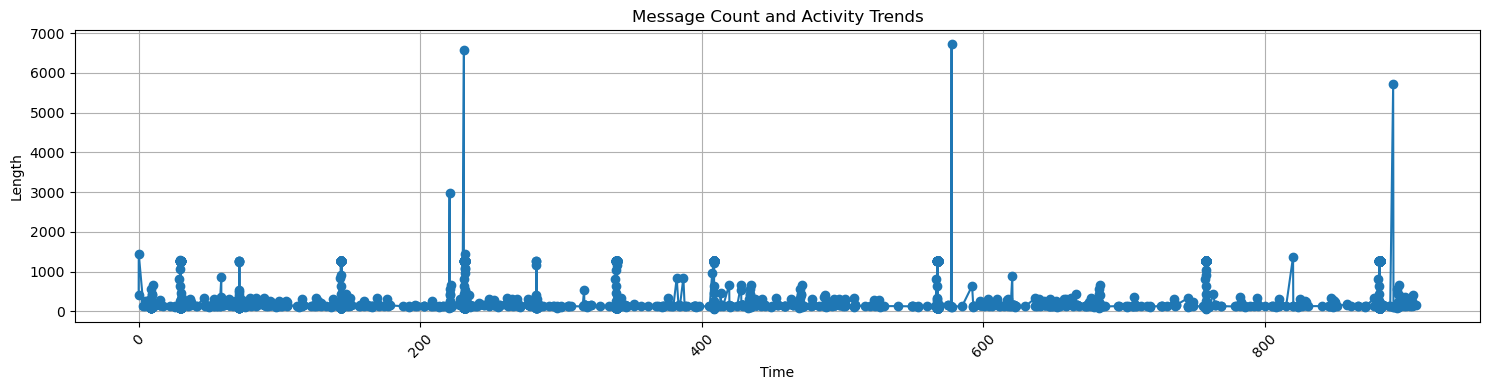

In [79]:
invalid = True
while invalid:
    answer = input("Please select which Whatsapp Group you want to clean:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos\n"
                           "5 - Mostly Files\n"
                           "6 - Noisy recording\n"
                           "7 - Exit\n")
    if answer != '1' and answer != '2' and answer != '3' and answer != '4' and answer != '5' and answer != '6' and answer != '7':
        print("Invalid value. Please enter a valid number\n")
    elif answer == '7':
        invalid = False
        print("Goodbye")
    else:
        invalid = False
        df, name = load_csv(answer)
        plot_activity_trends(df)

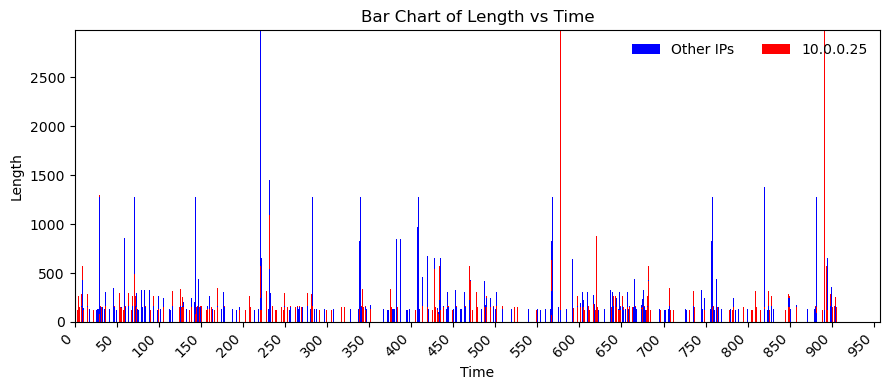

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
568,1147.0,231.021375,10.0.2.15,157.240.214.60,TLSv1.2,6581.0,Application Data,0.978846,6450.0
1769,2947.0,577.438892,10.0.2.15,157.240.214.60,TLSv1.2,6734.0,Application Data,0.430866,6609.0
2687,4283.0,891.110688,10.0.2.15,157.240.214.60,TLSv1.2,5726.0,Application Data,2.090165,5602.0


In [80]:
threshold, fig = colored_bar_plot(df)
df[df["Length"]>threshold]

In [81]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.214.60,TLSv1.2,413.0,Application Data,0.000000,0.0
1,3.0,0.076831,157.240.214.60,10.0.2.15,TCP,1446.0,"443 > 35260 [PSH, ACK] Seq=1 Ack=360 Win=655...",0.076831,1033.0
2,7.0,3.435388,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,3.358556,1322.0
3,9.0,4.648562,10.0.2.15,157.240.214.60,TLSv1.2,269.0,Application Data,1.213174,145.0
4,11.0,4.808730,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,0.160168,145.0
...,...,...,...,...,...,...,...,...,...
2728,4396.0,905.356649,157.240.214.60,10.0.2.15,TLSv1.2,151.0,Application Data,0.164875,1.0
2729,4398.0,905.364107,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,0.007458,1.0
2730,4400.0,905.506044,157.240.214.60,10.0.2.15,TLSv1.2,150.0,Application Data,0.141937,0.0
2731,4402.0,905.558160,10.0.2.15,157.240.214.60,TLSv1.2,149.0,Application Data,0.052116,1.0


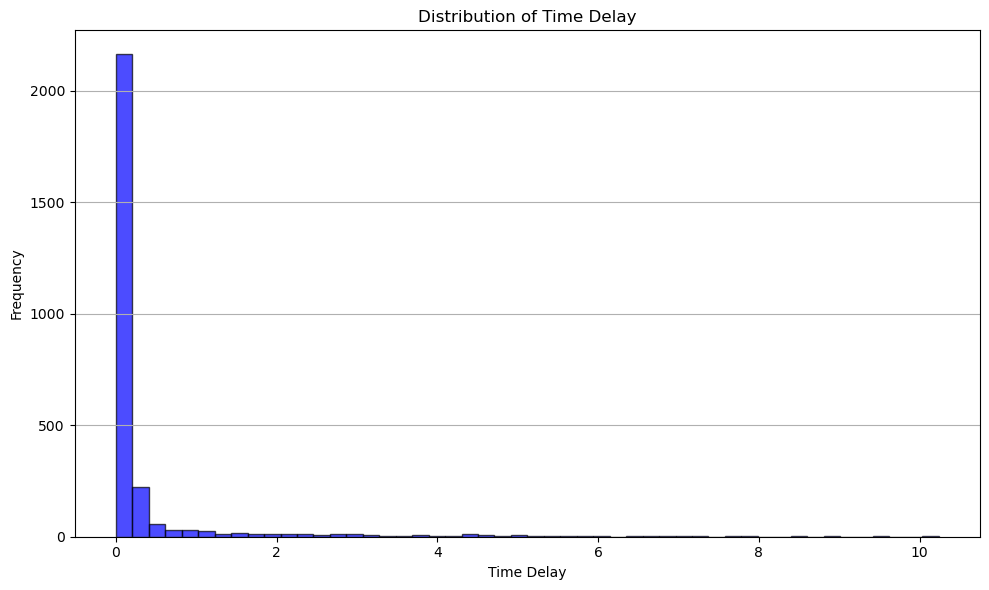

count    2733.000000
mean        0.332023
std         1.051056
min         0.000000
25%         0.000000
50%         0.000447
75%         0.134527
max        10.240512
Name: Time_delay, dtype: float64

In [82]:
plot_time_delay_distribution(df)
df['Time_delay'].describe()

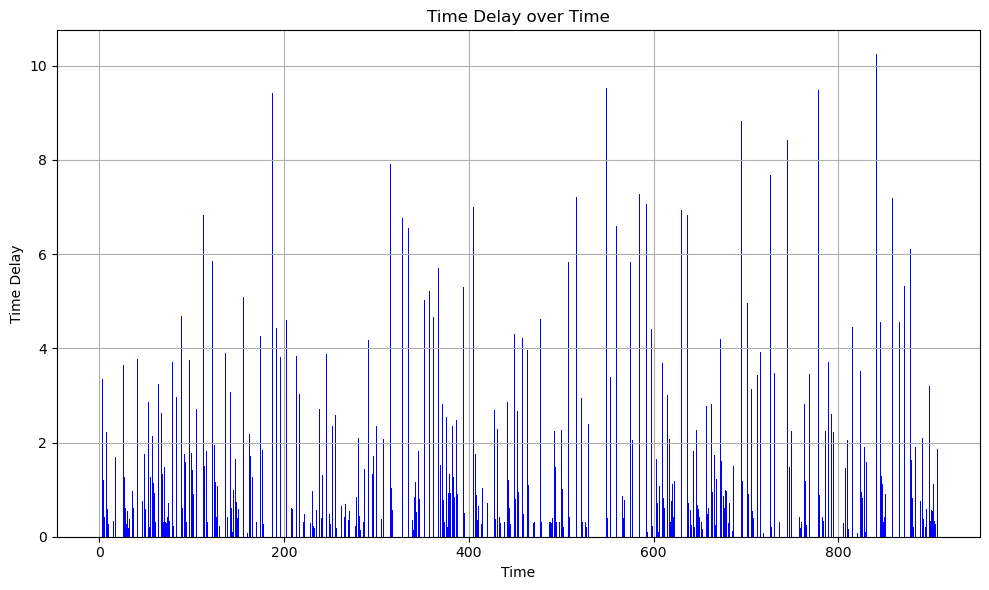

In [83]:
plot_time_delay_over_time(df)

In [84]:
length_range_counts = count_length_ranges(df)
print("Count the amount of packets's length in each range")
for range_name, count in length_range_counts.items():
    print(f"range: {range_name} - {count}")

Count the amount of packets's length in each range
range: 0-50 - 0
range: 51-100 - 705
range: 100-500 - 1061
range: 501-1000 - 43
range: 1001-1500 - 920
range: >1500 - 4


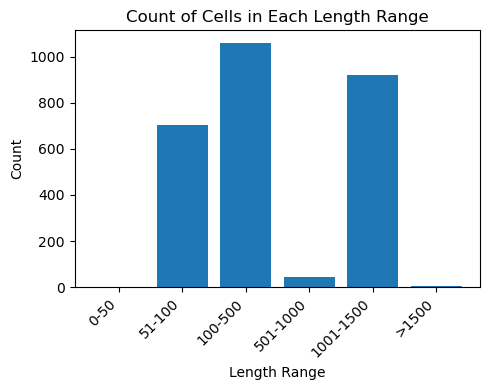

In [85]:
plot_length_range_counts(length_range_counts)

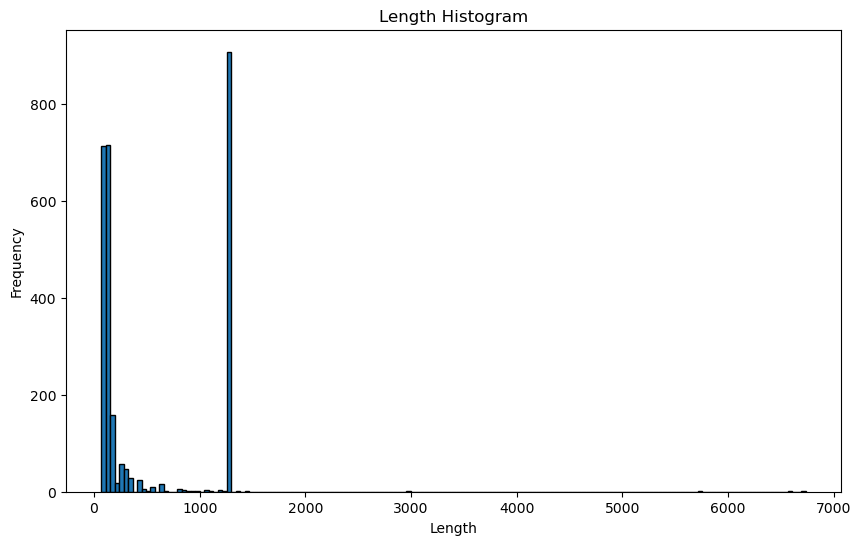

1769
6734.0


In [86]:
plot_length_histogram(df)
print (np.argmax(df["Length"]))
print (np.max(df["Length"]))

In [87]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.214.60,TLSv1.2,413.0,Application Data,0.000000,0.0
1,3.0,0.076831,157.240.214.60,10.0.2.15,TCP,1446.0,"443 > 35260 [PSH, ACK] Seq=1 Ack=360 Win=655...",0.076831,1033.0
2,7.0,3.435388,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,3.358556,1322.0
3,9.0,4.648562,10.0.2.15,157.240.214.60,TLSv1.2,269.0,Application Data,1.213174,145.0
4,11.0,4.808730,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,0.160168,145.0
...,...,...,...,...,...,...,...,...,...
2728,4396.0,905.356649,157.240.214.60,10.0.2.15,TLSv1.2,151.0,Application Data,0.164875,1.0
2729,4398.0,905.364107,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,0.007458,1.0
2730,4400.0,905.506044,157.240.214.60,10.0.2.15,TLSv1.2,150.0,Application Data,0.141937,0.0
2731,4402.0,905.558160,10.0.2.15,157.240.214.60,TLSv1.2,149.0,Application Data,0.052116,1.0


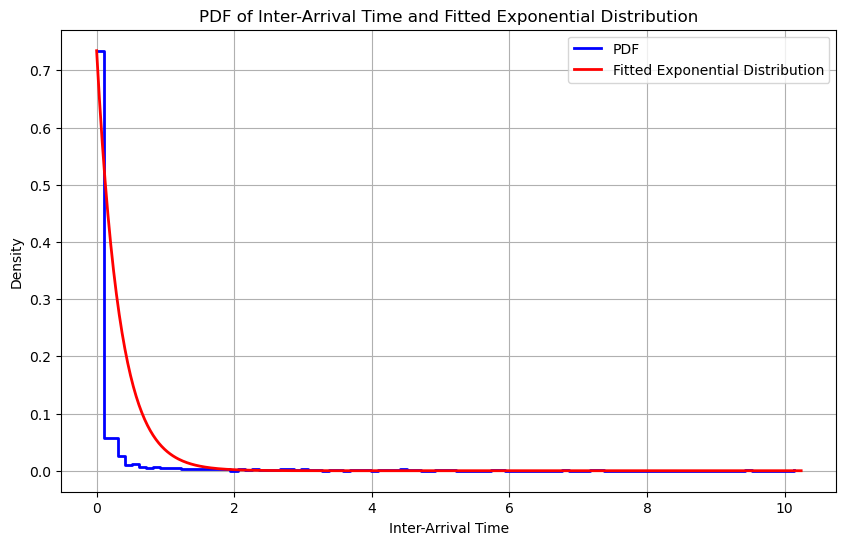

In [88]:
bin_edges, pdf = generate_pdf(df, bins=100)
fig = plot_pdf_with_fitted_exponential(df, bin_edges, pdf)

In [89]:
df[df["Time_delay"]<0]

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff


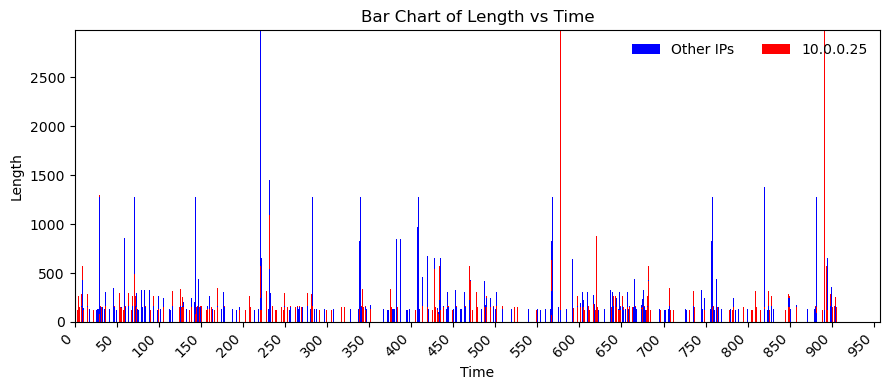

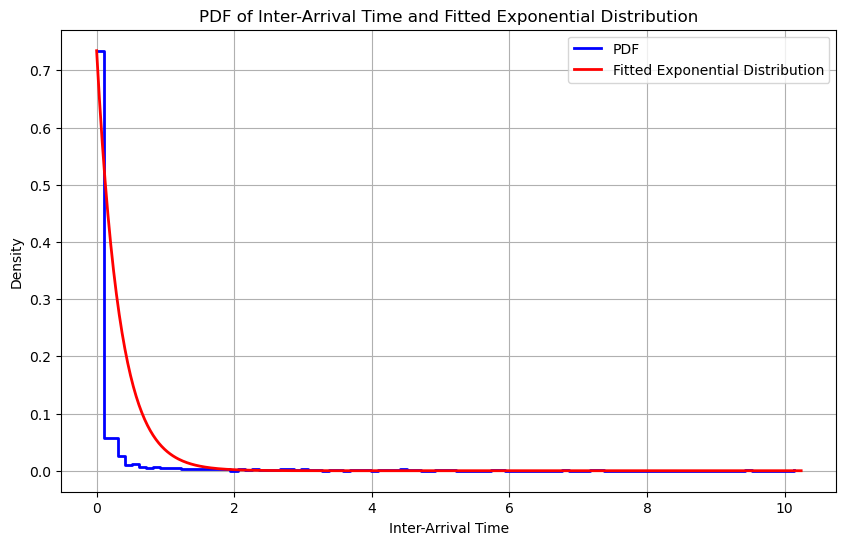

In [90]:
save_required_graphs(df, name)

## In this part we will look on all the groups with main theme and compute the CCDF for them

In [33]:
def load_all():
    base_path = r"C:\Ariel codes\networks\final project\Networks_Final_Project\resources\CLEAN"
    paths = [
        f"{base_path}/whatsappMessagesCSVClean.csv",
        f"{base_path}/whatsappImagesCSVClean.csv",
        f"{base_path}/whatsappAudioCSVClean.csv",
        f"{base_path}/whatsappVideosCSVClean.csv", 
        f"{base_path}/whatsappFilesCSVClean.csv"
    ]
    
    dataframes = []
    
    for p in paths:
        df = pd.read_csv(p, sep=',', header=0, usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
        reformat_columns(df)
        add_delays(df)
        add_lengths(df)
        dataframes.append(df)
    
    df1, df2, df3, df4, df5 = dataframes
    return df1, df2, df3, df4, df5


In [48]:
def compute_ccdf(column, big_threshold=0.7):  
    """Compute CCDF for a given dataframe column."""
    # Sort and normalize the data
    sorted_vals = np.sort(column)
    normalized_vals = sorted_vals / max(sorted_vals)

    # Compute CDF and then CCDF
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    ccdf = 1 - cdf
    
    return normalized_vals, ccdf

def plot_ccdf(dataframes, labels):
    """Plot CCDF for a list of dataframes (considering their 'Length' column)."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for df, label in zip(dataframes, labels):
        normalized_vals, ccdf = compute_ccdf(df['Length'])
        plt.plot(normalized_vals, ccdf, label=label)
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Normalized Message Sizes')
    plt.ylabel('CCDF')
    plt.title('CCDF of Packets Size Distribution')
    plt.legend(loc="lower left")
    plt.show()
    return fig

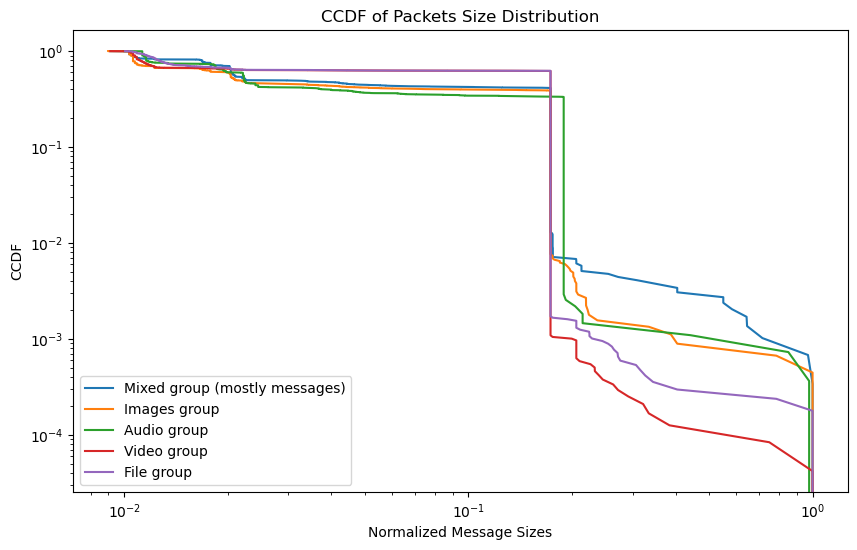

In [49]:
df1, df2, df3, df4, df5 = load_all()

dfs = [df1, df2, df3, df4, df5]
labels = ['Mixed group (mostly messages)', 'Images group', 'Audio group', 'Video group', 'File group']

fig = plot_ccdf(dfs, labels)

fig.savefig(r"C:\Ariel codes\networks\final project\Networks_Final_Project\res\whatsappComunicationTypesCCDF.png")

In [50]:
df_mixed, df_images, df_audio, df_videos, df_files = df1, df2, df3, df4, df5

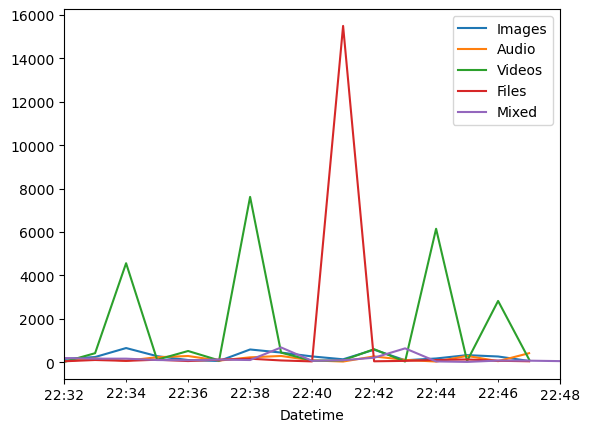

In [51]:
# 1. Convert to DateTime format
base_time = pd.Timestamp.now()  # or any other arbitrary start time
df_images['Datetime'] = base_time + pd.to_timedelta(df_images['Time'], unit='s')
df_audio['Datetime'] = base_time + pd.to_timedelta(df_audio['Time'], unit='s')
df_videos['Datetime'] = base_time + pd.to_timedelta(df_videos['Time'], unit='s')
df_files['Datetime'] = base_time + pd.to_timedelta(df_files['Time'], unit='s')
df_mixed['Datetime'] = base_time + pd.to_timedelta(df_mixed['Time'], unit='s')

# 2. Now plot the resampled data by minute
df_images.set_index('Datetime').resample('T').size().plot(label='Images')
df_audio.set_index('Datetime').resample('T').size().plot(label='Audio')
df_videos.set_index('Datetime').resample('T').size().plot(label='Videos')
df_files.set_index('Datetime').resample('T').size().plot(label='Files')
df_mixed.set_index('Datetime').resample('T').size().plot(label='Mixed')
plt.legend()
plt.show()


In [42]:
dfs = {'Images': df_images, 'Audio': df_audio, 'Videos': df_videos, 'Files': df_files, 'Mixed': df_mixed}

for name, df in dfs.items():
    print(name)
    print("Mean:", df['Length'].mean())
    print("Median:", df['Length'].median())
    print("Variance:", df['Length'].var())
    # Add more statistics as required
    print("------")

Images
Mean: 590.2623097582812
Median: 155.0
Variance: 357531.59180052264
------
Audio
Mean: 533.593487010611
Median: 150.0
Variance: 331351.81601905805
------
Videos
Mean: 832.1665263866678
Median: 1274.0
Variance: 331890.62691191706
------
Files
Mean: 838.881900560391
Median: 1274.0
Variance: 332855.6882516368
------
Mixed
Mean: 638.8996929375639
Median: 166.0
Variance: 393327.1162149332
------


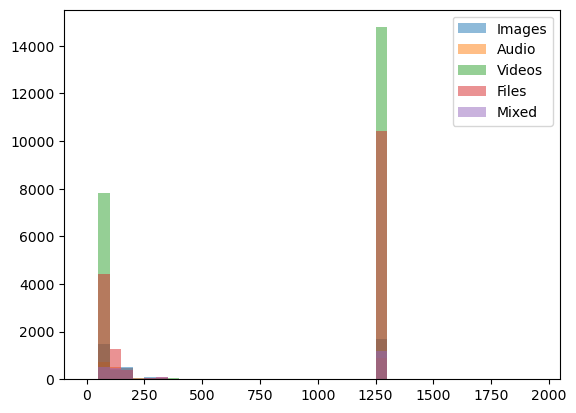

In [43]:
bins = range(0, 2000, 50)
for name, df in dfs.items():
    plt.hist(df['Length'], bins=bins, alpha=0.5, label=name)
plt.legend()
plt.show()

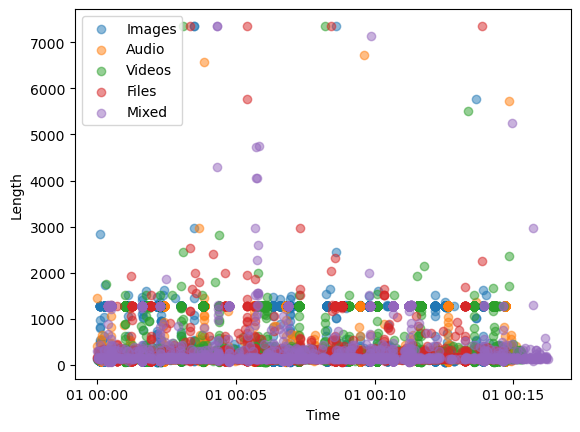

In [44]:
for name, df in dfs.items():
    plt.scatter(df['Time'], df['Length'], label=name, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Length')
plt.legend()
plt.show()

In [45]:
window_size = 10  # You can adjust this
for name, df in dfs.items():
    df['rolling_avg_length'] = df['Length'].rolling(window=window_size).mean()
    print(name, "Mean Rolling Average Length:", df['rolling_avg_length'].mean())

Images Mean Rolling Average Length: 591.1035209688248
Audio Mean Rolling Average Length: 534.3432085168849
Videos Mean Rolling Average Length: 832.4223003410125
Files Mean Rolling Average Length: 839.1627974947703
Mixed Mean Rolling Average Length: 640.3060574948666


## Now, we will take a look on a group where the attacked user is active in multiple groups

In [1]:
def read_together():
    path1 = work_path + "/whatsappAttackedRegularUseCSVClean.csv"
    path2 = work_path + "/whatsappAttackerRegularUseCSVClean.csv"
    
    df1 = pd.read_csv(path1)
    df2 = pd.read_csv(path2)
    
    return df1, df2

In [2]:
def together_bar_plot(df1, df2):
    plt.figure(figsize=(9, 4))
    
    # Colors and plot for df1
    colors_df1 = ['blue' if source != "10.0.2.15" else 'red' for source in df1["Source"]]
    plt.bar(df1["Time"], df1["Length"], color=colors_df1, label='DataFrame1', alpha=0.6)
    
    # Colors and plot for df2
    colors_df2 = ['green' if source != "10.0.2.15" else 'yellow' for source in df2["Source"]]
    plt.bar(df2["Time"], df2["Length"], color=colors_df2, label='DataFrame2', alpha=0.6)
    
    # Create custom bars for the legend
    blue_bar = plt.Rectangle((0,0),1,1,fc="blue", edgecolor='none')
    red_bar = plt.Rectangle((0,0),1,1,fc="red", edgecolor='none')
    green_bar = plt.Rectangle((0,0),1,1,fc="green", edgecolor='none')
    yellow_bar = plt.Rectangle((0,0),1,1,fc="yellow", edgecolor='none')
    
    # Add a legend
    l = plt.legend([blue_bar, red_bar, green_bar, yellow_bar], 
                   ['DF1 Other IPs', 'DF1 10.0.2.15', 'DF2 Other IPs', 'DF2 10.0.2.15'], 
                   loc=1, ncol=2, prop={'size':10})
    l.draw_frame(False)
    
    combined_df = pd.concat([df1, df2])
    y_axis_size = compute_y_axis_size(combined_df, 3)
    
    plt.xlim(0, max(combined_df["Time"]) + 50)
    plt.ylim(0, y_axis_size)
    
    plt.yticks(np.arange(0, y_axis_size, 500))
    plt.xticks(np.arange(0, max(combined_df["Time"]) + 50, 50))

    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return y_axis_size

In [3]:
def plot_bar_graphs(df1, df2):
    # Filtering conditions
    df1_source_10 = df1[df1['Source'] == '10.0.2.15']
    df2_source_10 = df2[df2['Source'] == '10.0.2.15']
    df1_source_not_10 = df1[df1['Source'] != '10.0.2.15']
    df2_source_not_10 = df2[df2['Source'] != '10.0.2.15']
    
    plt.figure(figsize=(15, 15))

    # Graph 1: df1 is 10.0.2.15 and df2 is not 10.0.2.15
    plt.subplot(3, 1, 1)
    plt.bar(df1_source_10['Time'], df1_source_10['Length'], color='r', label='df1: Source=10.0.2.15')
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='df2: Source!=10.0.2.15')
    plt.legend()
    plt.title('Source from df1 is 10.0.2.15 and source from df2 is NOT 10.0.2.15')
    plt.xlabel('Time')
    plt.ylabel('Length')

    # Graph 2: df2 is 10.0.2.15 and df1 is not 10.0.2.15
    plt.subplot(3, 1, 2)
    plt.bar(df2_source_10['Time'], df2_source_10['Length'], color='b', label='df2: Source=10.0.2.15')
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='df1: Source!=10.0.2.15')
    plt.legend()
    plt.title('Source from df2 is 10.0.2.15 and source from df1 is NOT 10.0.2.15')
    plt.xlabel('Time')
    plt.ylabel('Length')

    # Graph 3: Source from both df1 and df2 is not 10.0.2.15
    plt.subplot(3, 1, 3)
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='df1: Source!=10.0.2.15')
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='df2: Source!=10.0.2.15')
    plt.legend()
    plt.title('Source from both df1 and df2 is NOT 10.0.2.15')
    plt.xlabel('Time')
    plt.ylabel('Length')
    max_time = max(df1['Time'].max(), df2['Time'].max())
    ticks = list(range(0, int(max_time) + 50, 50))
    plt.xticks(ticks)

    plt.tight_layout()
    plt.show()

In [4]:
def align_and_plot(df1, df2):
    # watching the both communication, knowing that they are both in the same groups, we alined them to the same time axis
    offset = 434.799329 - 438.779966
    
    # Adjust the time values of df2
    df2["Adjusted Time"] = df2["Time"] + offset

    plt.figure(figsize=(10, 5))
    
    # Plot for df1
    colors_df1 = ['blue' if source != "10.0.2.15" else 'red' for source in df1["Source"]]
    plt.bar(df1["Time"], df1["Length"], color=colors_df1, alpha=0.6)
    
    # Plot for df2
    colors_df2 = ['green' if source != "10.0.2.15" else 'magenta' for source in df2["Source"]]
    plt.bar(df2["Adjusted Time"], df2["Length"], color=colors_df2, alpha=0.6)

    plt.xlabel("Adjusted Time")
    plt.ylabel("Length")
    plt.title("Combined Bar Chart of Length vs Adjusted Time")
    
    # Determine the combined y-axis size
    combined_df = pd.concat([df1, df2])
    y_axis_size = compute_y_axis_size(combined_df, 6)
    plt.ylim(0, y_axis_size)
    
    # Legend
    df1_non_ip = plt.Rectangle((0, 0), 1, 1, fc="blue", edgecolor='none')
    df1_ip = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor='none')
    df2_non_ip = plt.Rectangle((0, 0), 1, 1, fc="green", edgecolor='none')
    df2_ip = plt.Rectangle((0, 0), 1, 1, fc="magenta", edgecolor='none')
    
    plt.legend([df1_non_ip, df1_ip, df2_non_ip, df2_ip], ['Attacked: Recieved packets', 'Attacked: Sent packets', 'Attacker: Recieved packets', 'Attacker: Sent packets'], 
               loc="upper right", prop={'size':10})
    
    plt.tight_layout()
    plt.show()



In [5]:
def plot_two_dataframes(df1, df2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
    
    # Plot for df1
    colors_df1 = ['blue' if source != "10.0.2.15" else 'red' for source in df1["Source"]]
    ax1.bar(df1["Time"], df1["Length"], color=colors_df1, alpha=0.6)
    ax1.set_ylabel("Length")
    ax1.set_title("DataFrame 1: Bar Chart of Length vs Time")
    y_axis_size_df1 = compute_y_axis_size(df1, 3)
    ax1.set_ylim(0, y_axis_size_df1)
    ax1.legend(['Other IPs', '10.0.2.15'], loc=1, prop={'size':10})
    
    # Plot for df2
    colors_df2 = ['green' if source != "10.0.2.15" else 'orange' for source in df2["Source"]]
    ax2.bar(df2["Time"], df2["Length"], color=colors_df2, alpha=0.6)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Length")
    ax2.set_title("DataFrame 2: Bar Chart of Length vs Time")
    y_axis_size_df2 = y_axis_size_df1
    ax2.set_ylim(0, y_axis_size_df2)
    ax2.legend(['Other IPs', '10.0.2.15'], loc=1, prop={'size':10})
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_bar_graphs_separated(df1, df2):
    # Filtering conditions
    df1_source_10 = df1[df1['Source'] == '10.0.2.15']
    df2_source_10 = df2[df2['Source'] == '10.0.2.15']
    df1_source_not_10 = df1[df1['Source'] != '10.0.2.15']
    df2_source_not_10 = df2[df2['Source'] != '10.0.2.15']
    
    max_time = max(df1['Time'].max(), df2['Time'].max())
    max_length = max(df1['Length'].max(), df2['Length'].max())
    ticks = list(range(0, int(max_time) + 50, 50))
    
    plt.figure(figsize=(15, 20))

    # Graph 1: df1 is 10.0.2.15 and df2 is not 10.0.2.15
    plt.subplot(6, 1, 1)
    plt.bar(df1_source_10['Time'], df1_source_10['Length'], color='r', label='Attacker is sending')
    plt.legend()
    plt.title('Packets sent from attacker, attacked reciving')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    
    plt.subplot(6, 1, 2)
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='Attacked is recieving')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    # Graph 2: df2 is 10.0.2.15 and df1 is not 10.0.2.15
    plt.subplot(6, 1, 3)
    plt.bar(df2_source_10['Time'], df2_source_10['Length'], color='b', label='Attacked is sending')
    plt.legend()
    plt.title('Packets sent from attacked, attacker reciving')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)
    
    plt.subplot(6, 1, 4)
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='Attacker is recieving')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    # Graph 3: Source from both df1 and df2 is not 10.0.2.15
    plt.subplot(6, 1, 5)
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='Attacker is recieving')
    plt.legend()
    plt.title('Both attacker and attacked reciving')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)
    
    plt.subplot(6, 1, 6)
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='Attacked is recieving')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    plt.tight_layout()
    plt.show()


In [7]:
def filter_shared_seconds(df1, df2):
    # Round the time to the nearest second
    df1['Rounded_Time'] = df1['Time'].round()
    df2['Rounded_Time'] = df2['Time'].round()

    # Create a list of unique seconds that are present in both dataframes
    shared_seconds = set(df1['Rounded_Time']).intersection(set(df2['Rounded_Time']))

    # Filter both dataframes to keep only rows that are in the list of shared seconds
    df1_filtered = df1[df1['Rounded_Time'].isin(shared_seconds)]
    df2_filtered = df2[df2['Rounded_Time'].isin(shared_seconds)]

    return df1_filtered, df2_filtered

def filter_max_length_difference(df1, df2, threshold=2000):
    # Group by the rounded time and compute the max length for each second
    max_length_df1 = df1.groupby('Rounded_Time')['Length'].max()
    max_length_df2 = df2.groupby('Rounded_Time')['Length'].max()
    
    # Compute the difference between max lengths
    diff_max_lengths = abs(max_length_df1 - max_length_df2).dropna()
    
    # Get seconds where difference is below the threshold
    valid_seconds = diff_max_lengths[diff_max_lengths <= threshold].index
    
    # Filter both dataframes based on these valid seconds
    df1_filtered = df1[df1['Rounded_Time'].isin(valid_seconds)]
    df2_filtered = df2[df2['Rounded_Time'].isin(valid_seconds)]

    return df1_filtered, df2_filtered

In [28]:
def compute_cdf_df(df):
    """
    Compute CDF of packet lengths over time.

    Args:
    - df (pd.DataFrame): The dataframe containing 'Time' and 'Length' columns.
    
    Returns:
    - times, cdf
    """
    # Sort dataframe by time
    df_sorted = df.sort_values(by='Time')

    # Calculate cumulative sum of packet lengths
    cumulative_lengths = df_sorted['Length'].cumsum()

    # Normalize the cumulative lengths to get CDF values
    cdf = cumulative_lengths / cumulative_lengths.iloc[-1]

    return df_sorted['Time'], cdf

def plot_cdfs_on_same_graph(df1, df2, label1='attacked', label2='attacker'):
    time1, cdf1 = compute_cdf_df(df1)
    time2, cdf2 = compute_cdf_df(df2)
    
    plt.figure(figsize=(10, 6))
    
    # Plot CDFs
    plt.plot(time1, cdf1, label=label1)
    plt.plot(time2, cdf2, label=label2)
    
    plt.xlabel('Time')
    plt.ylabel('CDF of Packet Lengths')
    plt.title('CDF of Packet Lengths Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
def compute_cdf_srs(series):
    """
    Compute the values of the CDF for a given series.
    
    Args:
    - series (pd.Series): Series of values.
    
    Returns:
    - sorted_series (pd.Series): Sorted values of the series.
    - cdf_values (pd.Series): CDF values.
    """
    sorted_series = series.sort_values().reset_index(drop=True)
    cdf_values = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    return sorted_series, cdf_values

def plot_cdfs(df1, df2, column_name='Length'):
    # Filter dataframes based on the conditions
    filtered_df1 = df1[df1['Destination'] == '10.0.2.15']
    filtered_df2 = df2[df2['Source'] == '10.0.2.15']
    
    # Compute CDF values
    sorted_values_df1, cdf_values_df1 = compute_cdf_srs(filtered_df1[column_name])
    sorted_values_df2, cdf_values_df2 = compute_cdf_srs(filtered_df2[column_name])
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_values_df1, cdf_values_df1, label=f"Destination=10.0.2.15")
    plt.plot(sorted_values_df2, cdf_values_df2, label=f"Source=10.0.2.15", linestyle='--')
    
    plt.xlabel(f"{column_name}")
    plt.ylabel(f"CDF")
    plt.title('CDF of Lengths Through Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def compute_cdf_values(series):
    """
    Compute the values of the CDF for a given series.
    
    Args:
    - series (pd.Series): Sorted series of values.
    
    Returns:
    - cdf_values (pd.Series): CDF values.
    """
    # Calculate cumulative sum
    cumulative_lengths = series.cumsum()
    cdf_values = cumulative_lengths / cumulative_lengths.iloc[-1]
    
    return cdf_values

def correlation_between_cdfs(df1, df2, column_name='Length'):
    # Filter dataframes based on the conditions
    filtered_df1 = df1[df1['Destination'] == '10.0.2.15'].sort_values(by=column_name)[column_name]
    filtered_df2 = df2[df2['Source'] == '10.0.2.15'].sort_values(by=column_name)[column_name]
    
    # Compute CDF values
    cdf_values_df1 = compute_cdf_values(filtered_df1)
    cdf_values_df2 = compute_cdf_values(filtered_df2)
    
    # Equalize lengths for plotting and correlation calculation
    min_length = min(len(cdf_values_df1), len(cdf_values_df2))
    cdf_values_df1 = cdf_values_df1[:min_length]
    cdf_values_df2 = cdf_values_df2[:min_length]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(cdf_values_df1, cdf_values_df2, alpha=0.5)
    plt.xlabel(f"CDF values for Destination=10.0.2.15")
    plt.ylabel(f"CDF values for Source=10.0.2.15")
    plt.title('Correlation between CDF Steps')
    plt.grid(True)
    plt.show()
    
    # Calculate and print Pearson correlation
    correlation = np.corrcoef(cdf_values_df1, cdf_values_df2)[0, 1]
    print(f"Pearson correlation between CDFs: {correlation:.4f}")

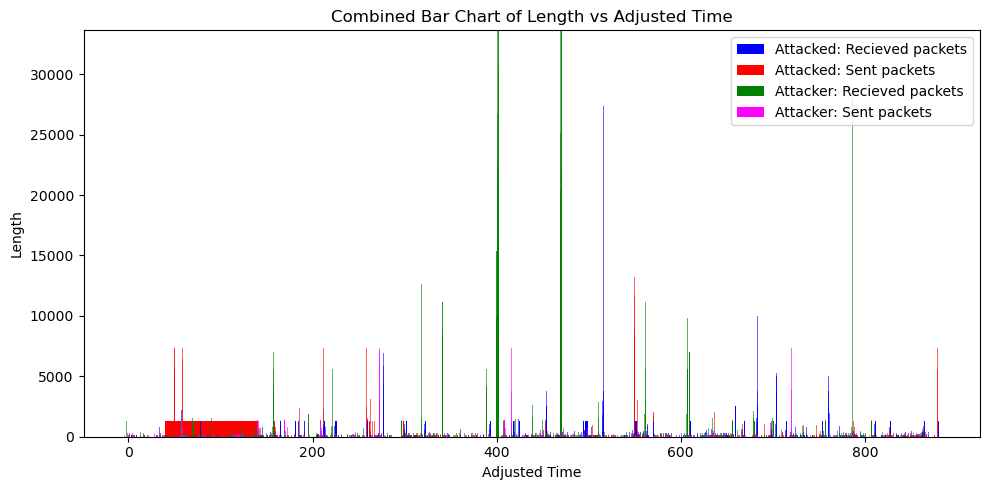

In [17]:
attacked, attacker = read_together()
align_and_plot(attacked, attacker)
# plot_two_dataframes(attacked, attacker)
# together_bar_plot(attacker, attacked)

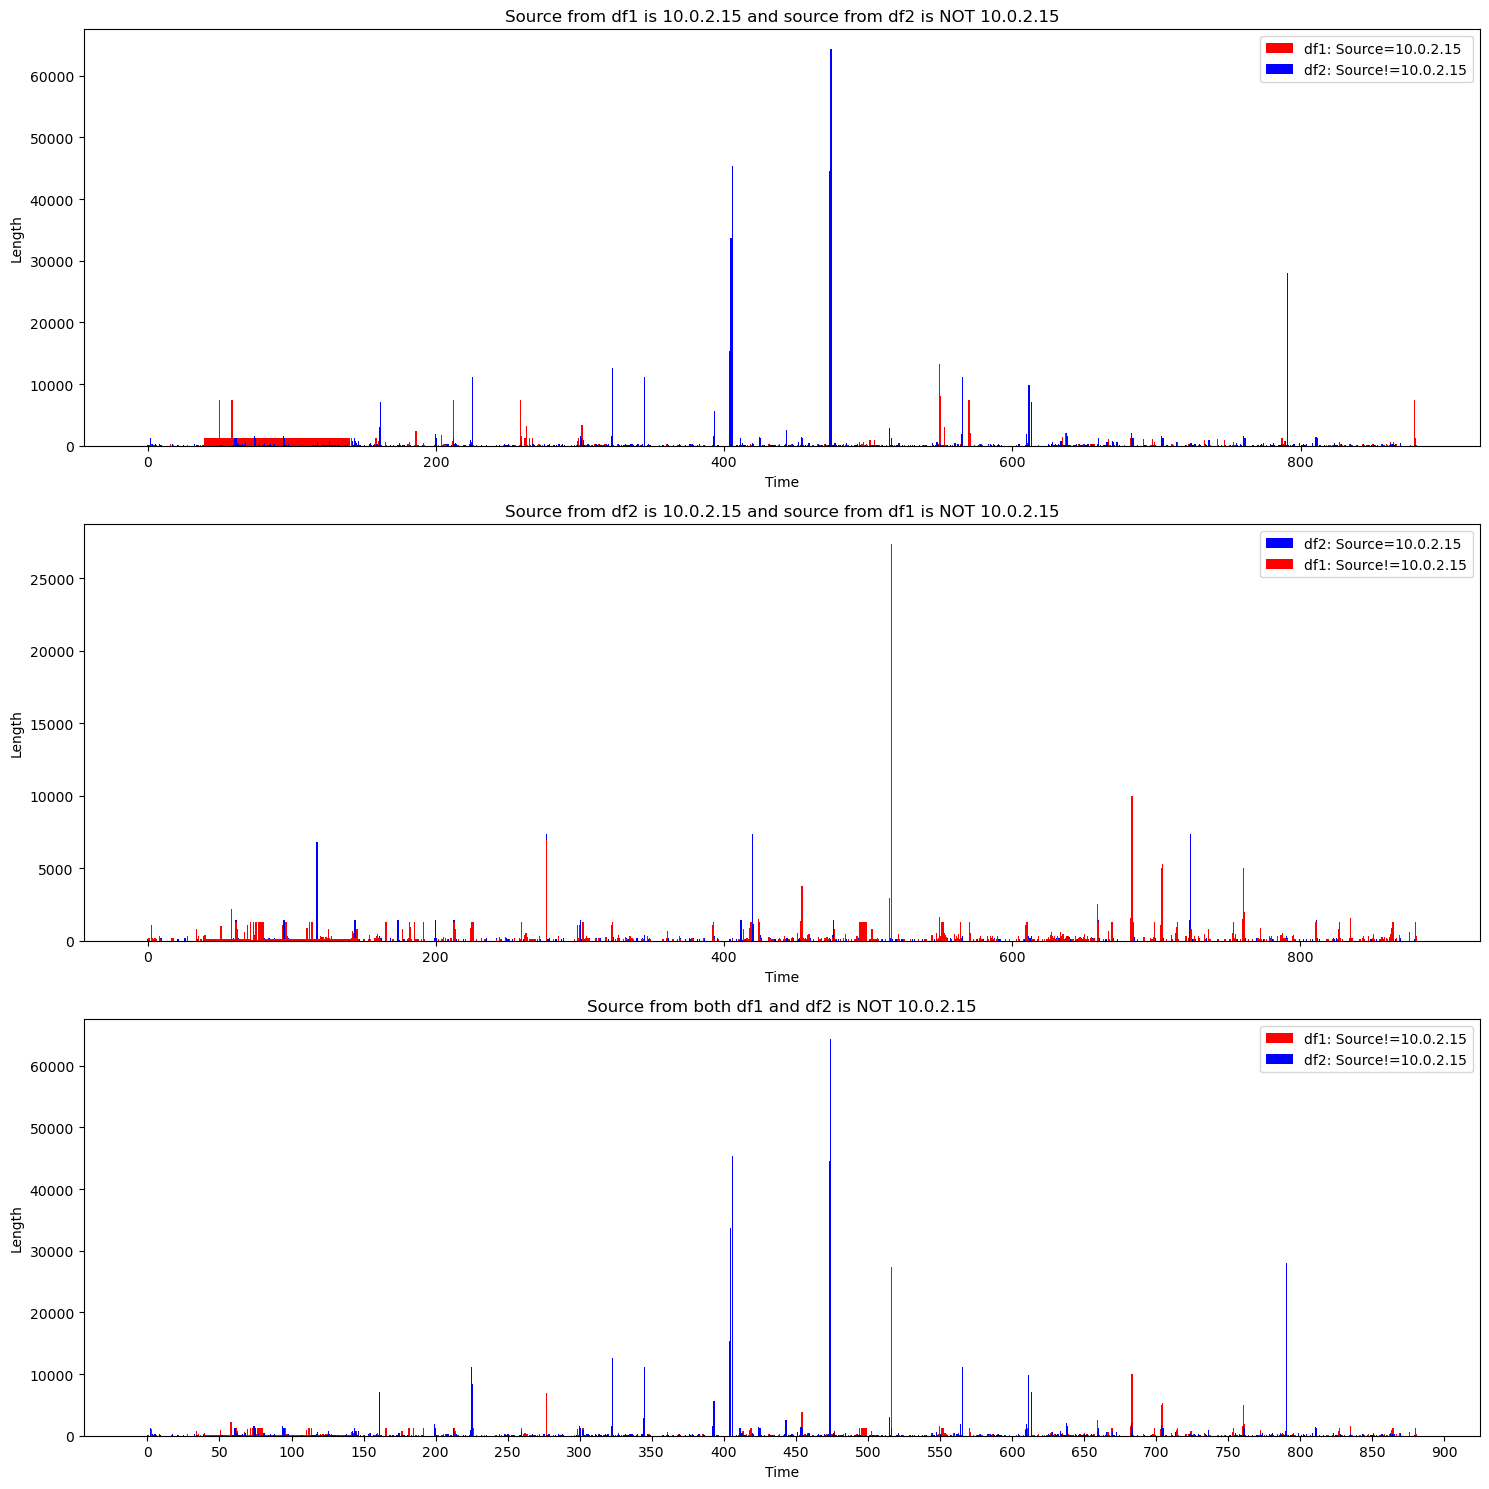

In [18]:
plot_bar_graphs(attacked, attacker)

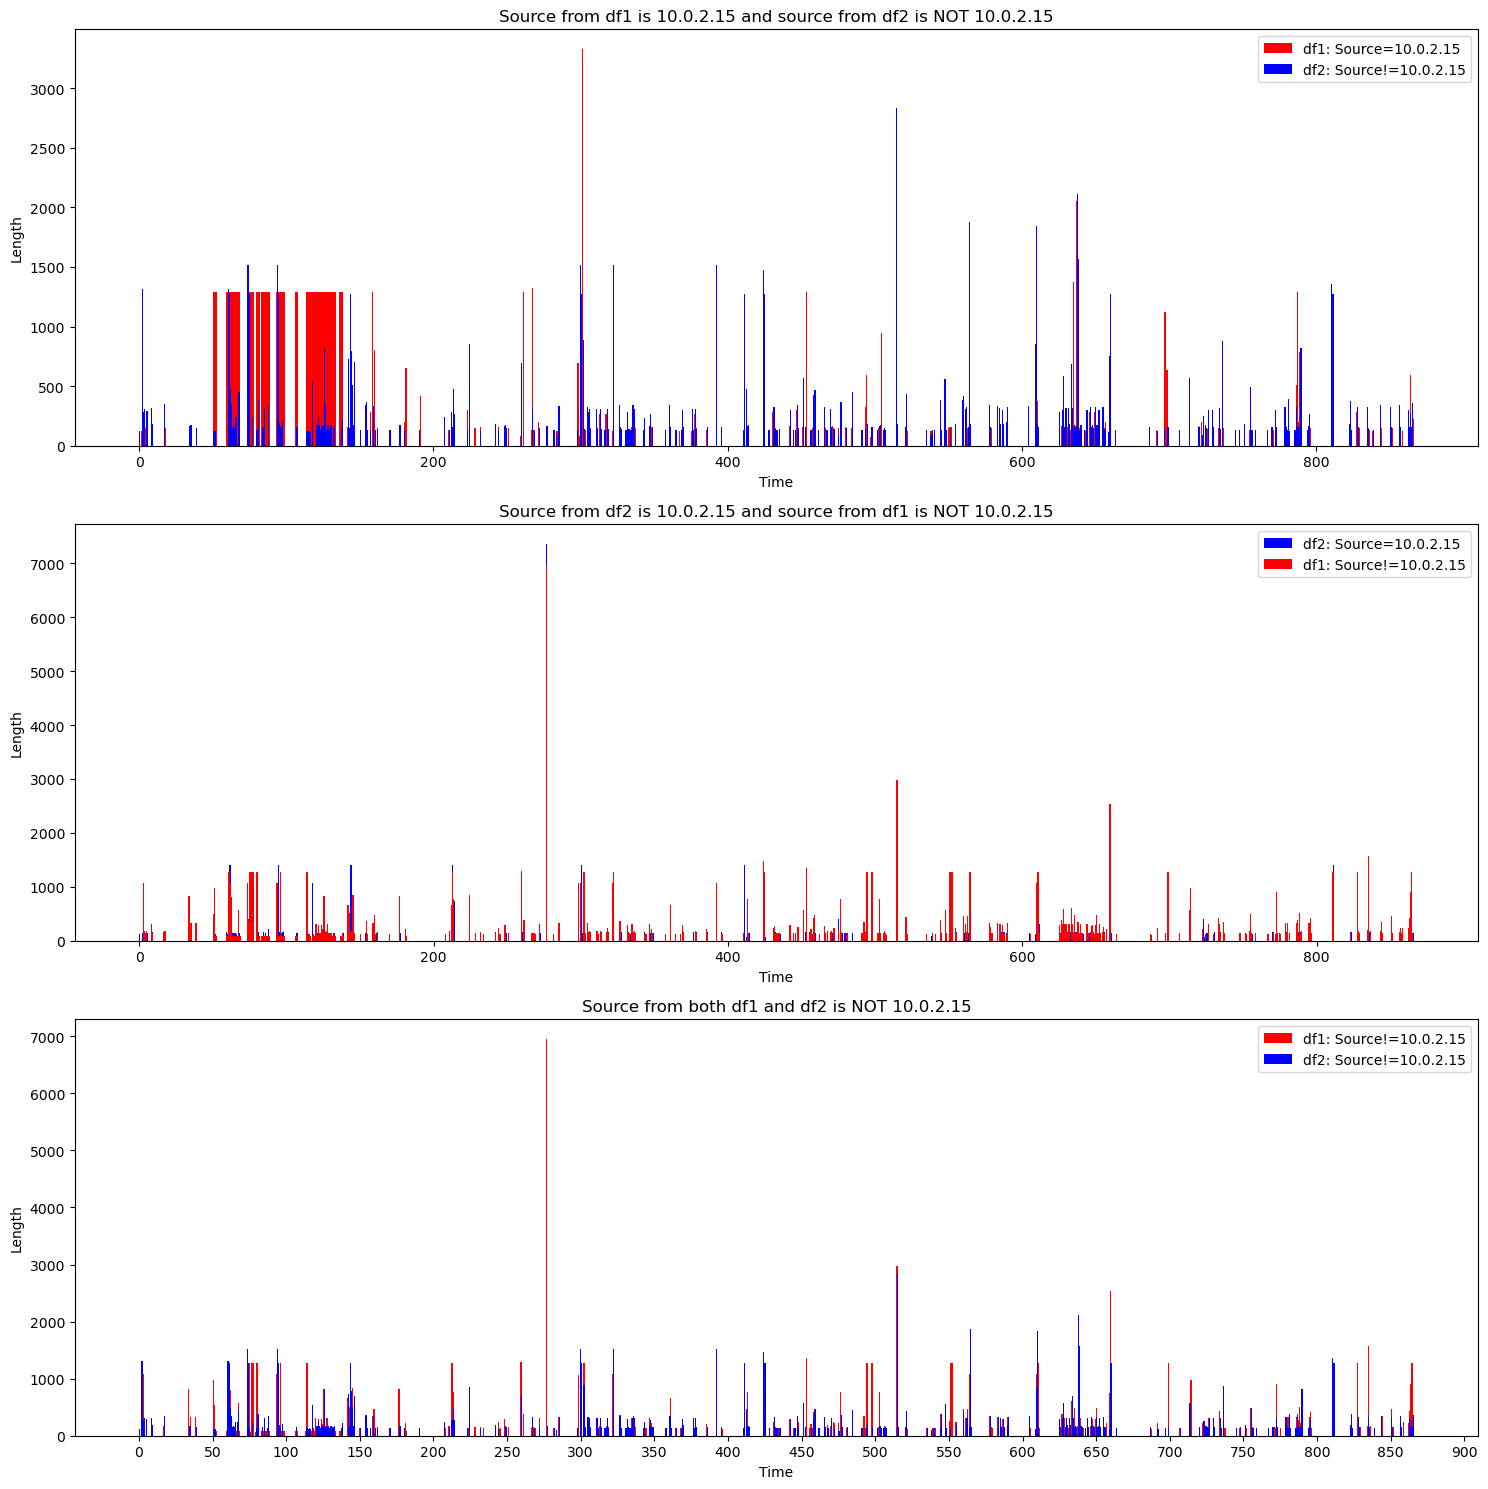

In [22]:
df1, df2 = attacked, attacker

# First, apply the shared seconds filtering function
df1_shared, df2_shared = filter_shared_seconds(df1, df2)

# Then apply the max length difference filtering function
df1_final, df2_final = filter_max_length_difference(df1_shared, df2_shared)

plot_bar_graphs(df1_final, df2_final)

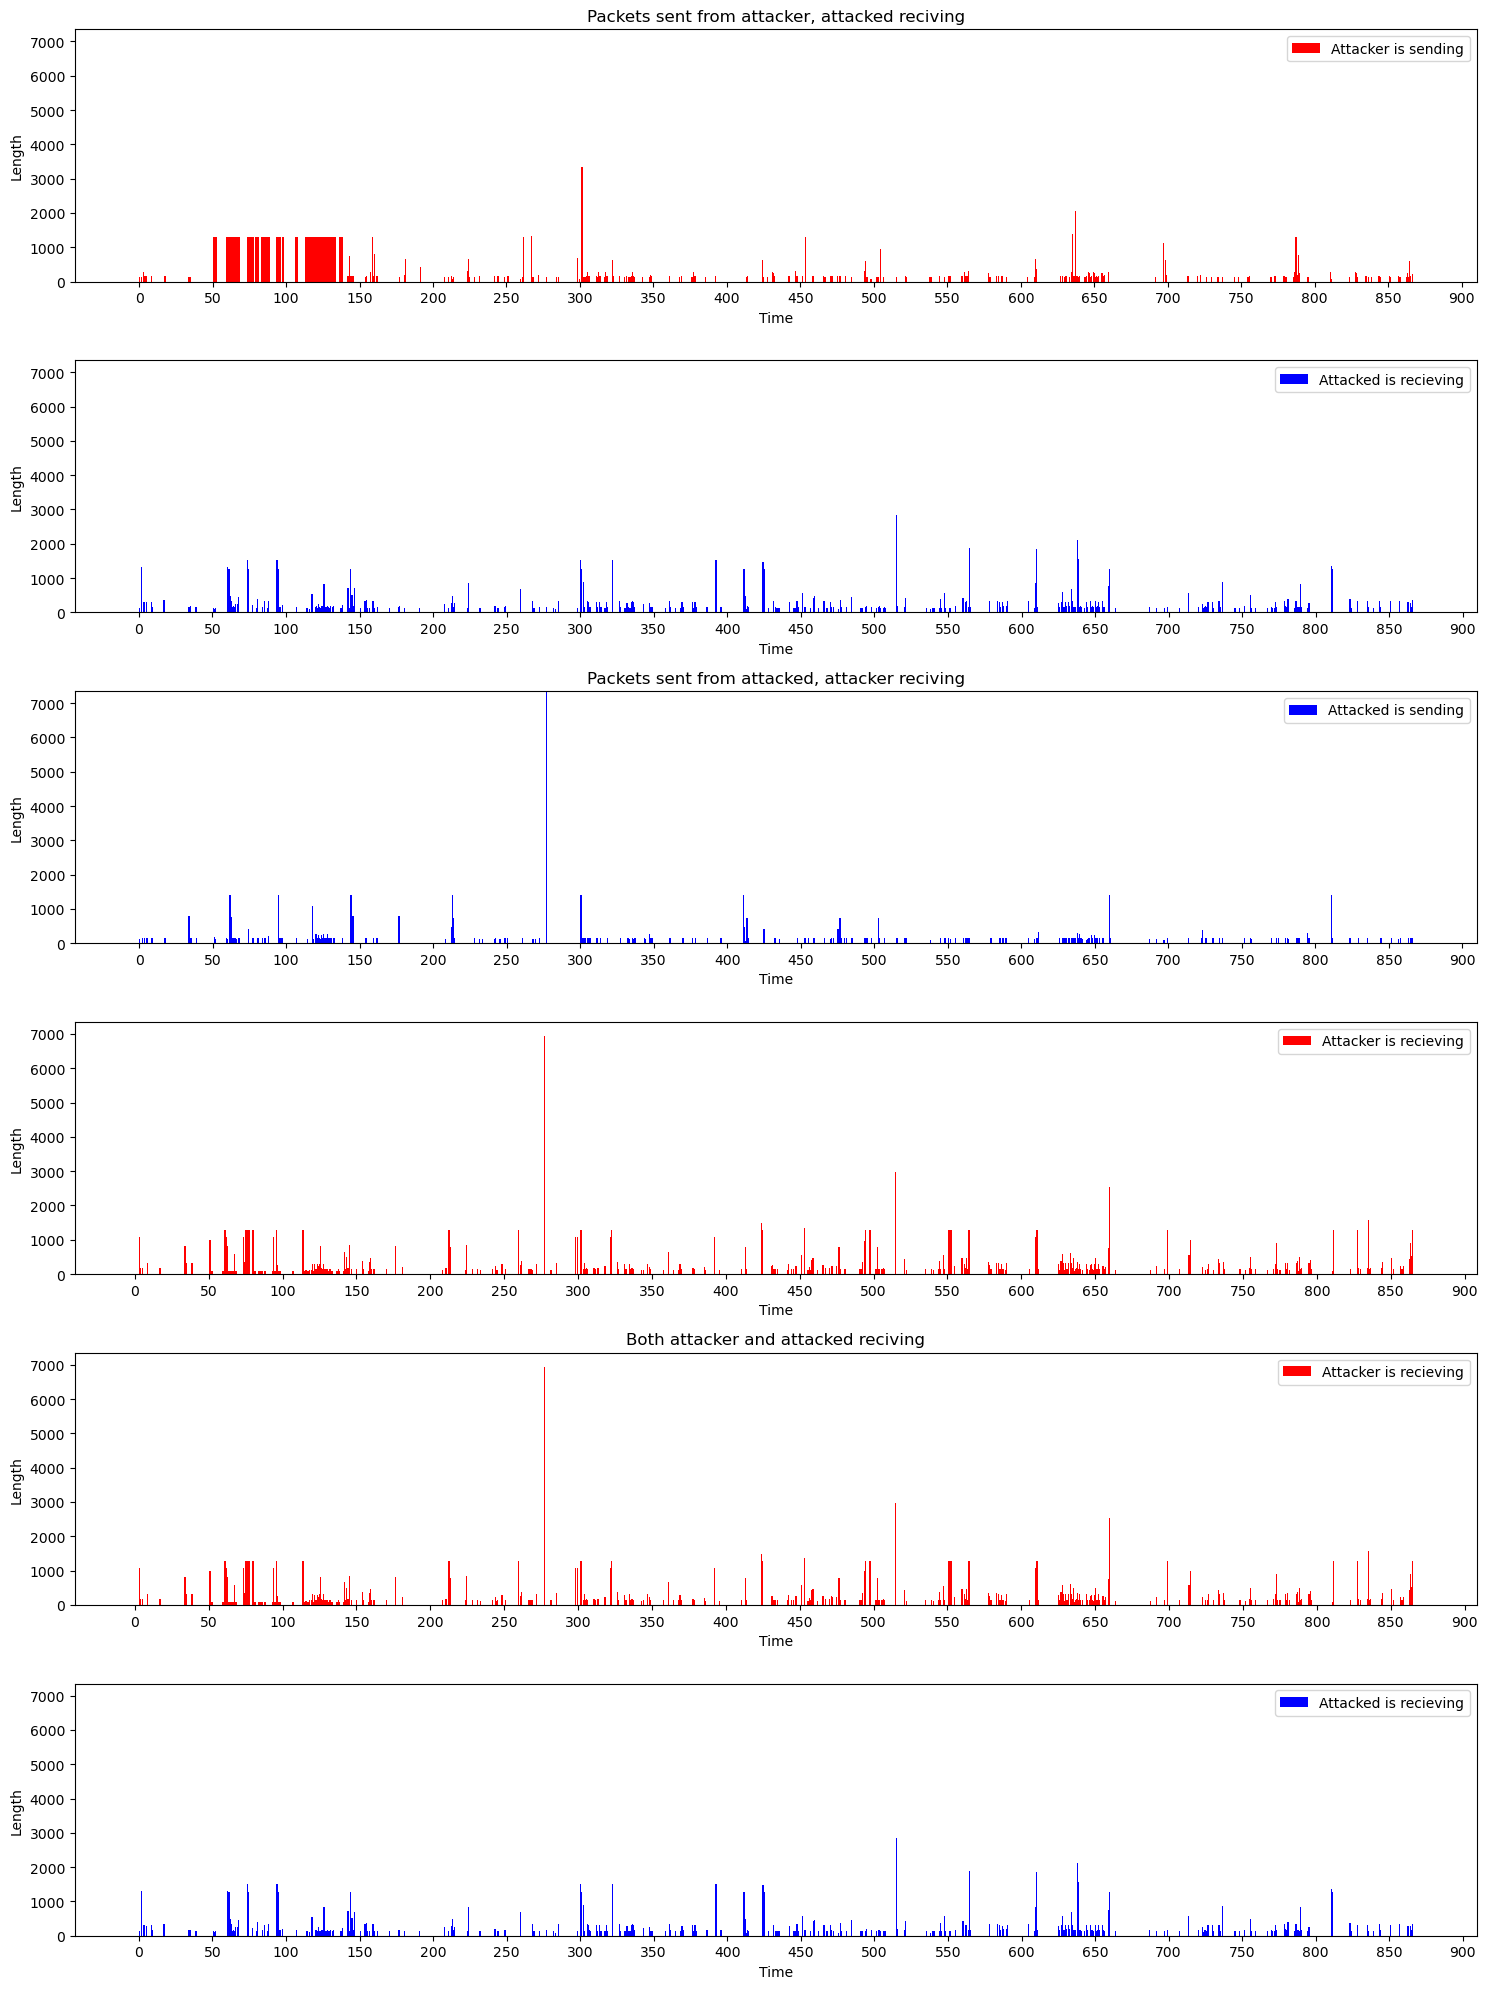

In [23]:
plot_bar_graphs_separated(df1_final, df2_final)

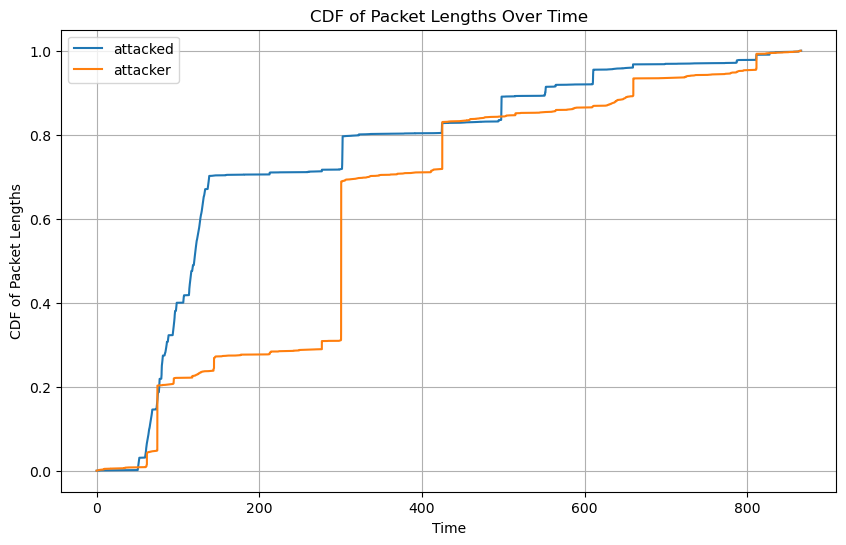

In [32]:
plot_cdfs_on_same_graph(df1_final, df2_final)

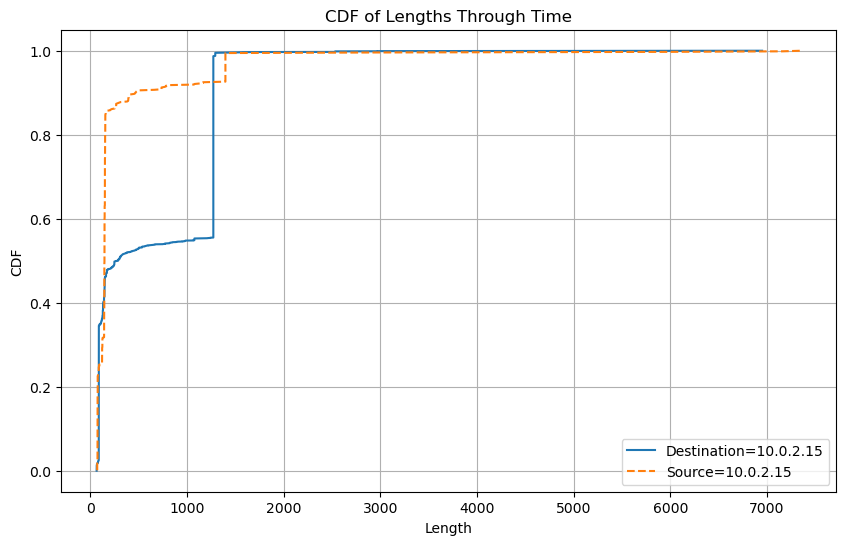

In [33]:
plot_cdfs(df1_final, df2_final)

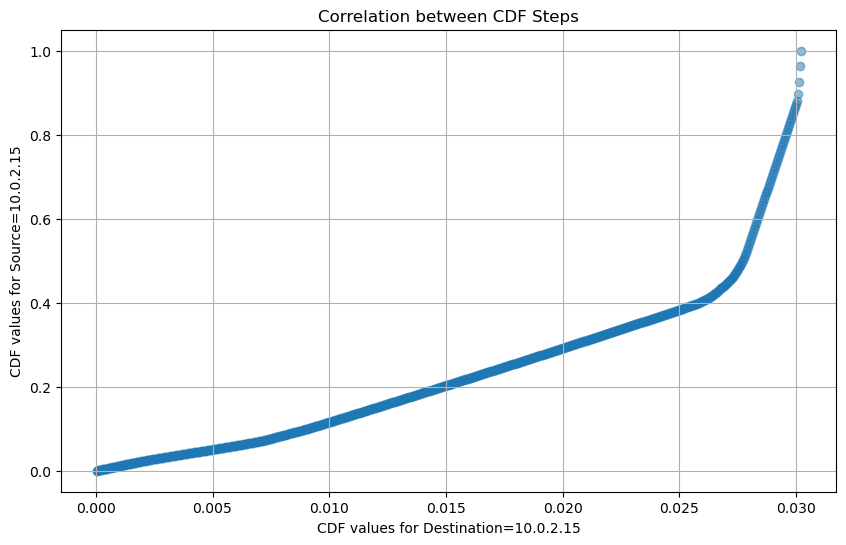

Pearson correlation between CDFs: 0.9271


In [34]:
correlation_between_cdfs(df1_final, df2_final)